# Model Evaluation & Explainability Setup

This notebook evaluates the fine-tuned LoRA-adapted RoBERTa model across multiple news datasets and exports explainability-ready samples (for SHAP/LIME).
It integrates quantitative metrics, confusion matrices, ROC curves, and qualitative error inspection.

In [1]:
import os, sys, json, torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

BASE_DIR  = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR  = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

MODEL_BEST = next((d for d in os.listdir(MODEL_DIR) if "multidomain_best" in d), None)
if MODEL_BEST is None:
    raise FileNotFoundError("No model folder containing 'multidomain_best' found in models/")

CKPT_PATH  = os.path.join(MODEL_DIR, MODEL_BEST)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(CKPT_PATH)
model = AutoModelForSequenceClassification.from_pretrained(CKPT_PATH).to(device)
model.eval()

print(f"Loaded best model checkpoint from: {CKPT_PATH}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded best model checkpoint from: /gpfs/home/ashwin/FakeNews-Detection/models/roberta_lora_multidomain_best


## Step 1 — Load Processed Datasets

In [2]:
liar_path = os.path.join(DATA_DIR, "processed_LIAR.csv")
fake_path = os.path.join(DATA_DIR, "processed_FakeNews.csv")

df_liar = pd.read_csv(liar_path)
df_fake = pd.read_csv(fake_path)

print(f"LIAR → {df_liar.shape}, FakeNews → {df_fake.shape}")
display(df_liar.head(2))

LIAR → (12791, 3), FakeNews → (44898, 3)


,title,text,label
0,abortion,Says the Annies List political group supports ...,1
1,"energy,history,job-accomplishments",When did the decline of coal start? It started...,0


## Step 2 — Dataset Preparation

In [3]:
from torch.utils.data import Dataset, DataLoader

class EvalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts  = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.texts)

# Create loaders
test_liar = DataLoader(EvalDataset(df_liar, tokenizer), batch_size=32, shuffle=False)
test_fake = DataLoader(EvalDataset(df_fake, tokenizer), batch_size=32, shuffle=False)

## Step 3 — Evaluation Routine

In [4]:
@torch.no_grad()
def evaluate_dataset(model, dataloader, name="Dataset"):
    preds, trues, probs = [], [], []
    model.eval()

    for batch in tqdm(dataloader, desc=f"Evaluating on {name}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        trues.extend(batch["labels"].cpu().numpy())
        probs.extend(torch.softmax(logits, dim=-1)[:, 1].cpu().numpy())

    report = classification_report(trues, preds, output_dict=True, zero_division=0)
    return np.array(trues), np.array(preds), np.array(probs), report

## Step 4 — Execute Evaluation

In [5]:
datasets = {"LIAR": test_liar, "FakeNews": test_fake}
reports = {}

for name, loader in datasets.items():
    y_true, y_pred, y_prob, report = evaluate_dataset(model, loader, name)
    reports[name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "report": report
    }

Evaluating on LIAR:   0%|          | 0/400 [00:00<?, ?it/s]

Evaluating on FakeNews:   0%|          | 0/1404 [00:00<?, ?it/s]

## Step 5 — Aggregate Metrics

In [6]:
summary = []
for name, d in reports.items():
    weighted = d["report"]["weighted avg"]
    summary.append({
        "Dataset": name,
        "Accuracy": d["report"]["accuracy"],
        "Precision": weighted["precision"],
        "Recall": weighted["recall"],
        "F1": weighted["f1-score"]
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

summary_path = os.path.join(MODEL_DIR, "roberta_lora_multidomain_evaluation_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Saved summary → {summary_path}")

,Dataset,Accuracy,Precision,Recall,F1
0,LIAR,0.443124,0.753502,0.443124,0.273116
1,FakeNews,0.772885,0.845835,0.772885,0.763264


Saved summary → /gpfs/home/ashwin/FakeNews-Detection/models/roberta_lora_multidomain_evaluation_summary.csv


## Step 6 — Confusion Matrix and ROC

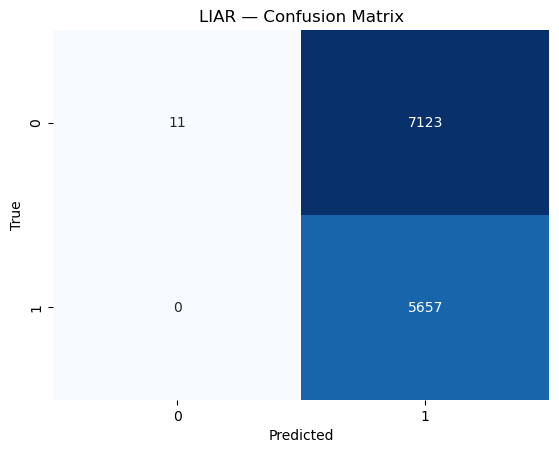

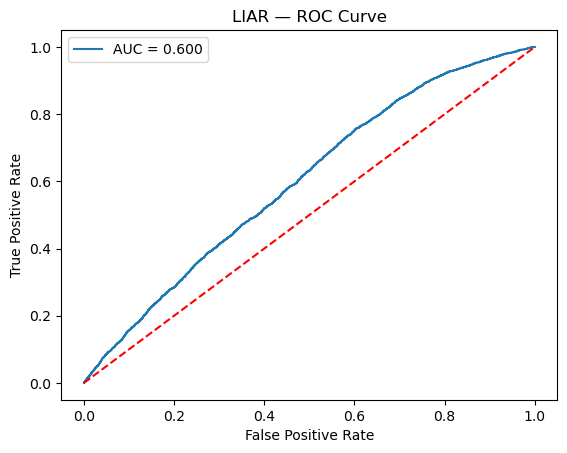

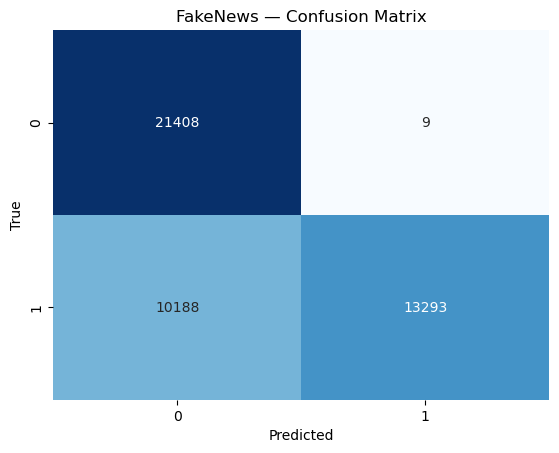

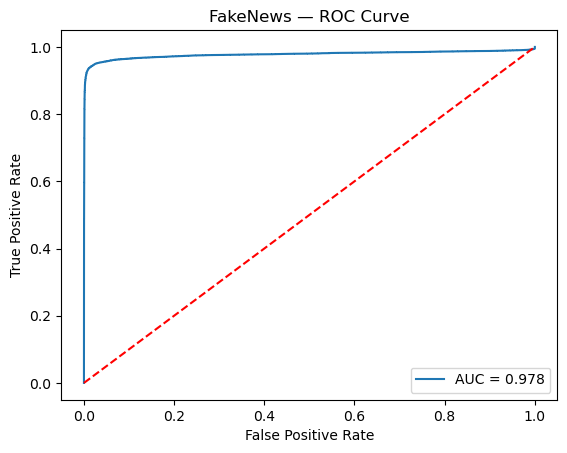

In [7]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"r--")
    plt.title(f"{title} — ROC Curve")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.show()

for name, d in reports.items():
    plot_confusion(d["y_true"], d["y_pred"], name)
    plot_roc(d["y_true"], d["y_prob"], name)

## Step 7 — Error Inspection

In [8]:
def sample_misclassified(df, y_true, y_pred, n=8):
    df_eval = df.copy()
    df_eval["predicted"] = y_pred
    df_eval["correct"] = df_eval["predicted"] == y_true
    errors = df_eval[~df_eval["correct"]].sample(n=n, random_state=42)
    return errors[["text", "label", "predicted"]]

mis_liar = sample_misclassified(df_liar, reports["LIAR"]["y_true"], reports["LIAR"]["y_pred"])
mis_fake = sample_misclassified(df_fake, reports["FakeNews"]["y_true"], reports["FakeNews"]["y_pred"])

display(mis_liar.head(5))

,text,label,predicted
6424,In the last six years of Ciancis administratio...,0,1
3670,Obamacare was patterned after (Mitt Romneys) p...,0,1
2822,"In Wisconsin, only half of all the adults with...",0,1
7597,Thirty-one percent of school districts are sti...,0,1
11404,"After losing 750,000 jobs a month before this ...",0,1


## Step 9 — Consolidated Summary

In [11]:
print("=== Model Evaluation Summary ===")
display(summary_df.style.background_gradient(cmap="Blues", axis=None))

print("\nBest Checkpoint →", CKPT_PATH)

=== Model Evaluation Summary ===


,Dataset,Accuracy,Precision,Recall,F1
0,LIAR,0.443124,0.753502,0.443124,0.273116
1,FakeNews,0.772885,0.845835,0.772885,0.763264



Best Checkpoint → /gpfs/home/ashwin/FakeNews-Detection/models/roberta_lora_multidomain_best
